- For our positive controls, ideally we’d like to establish a reference ORF paired with two mutants, one showing strong shifts and one subtle in the protein channel as well as detectable changes in morphology. In this case, profiling would especially be helpful. For the NegCons, we must slim down our selection to only 4 ORFs – I’m not sure if you guys have preference for selection there.


- Regarding the PosCons, we’d like to select either IMPDH1 or ALK as our reference allele, 
  plus two of their respective variants (one which shows strong morphological shifts/localization patterns,
  and one that’s subtle). For NegCons, we can only select 4 to include in our screen – 
  I’ll leave it up to you guys which 4 best suit your needs.


- You can disregard all wells that are not labelled either PosCon or NegCon for this screen. 
  And please keep in mind each quadrant received a varying dose of viral supernatant. 
  The amount I settled on for our final pipeline is 6 uL, so perhaps you want to pay attention to the wells which     received a vTitre = 6.


In [32]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import sklearn.preprocessing as sp
import pickle
# from imblearn.over_sampling import SMOTE  
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import os

from scipy.stats import pearsonr
import scipy
from matplotlib import rcParams
from sklearn.cluster import KMeans
import sys
sys.path.insert(0, '/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/') 
from singlecell.preprocess import handle_nans, extract_cpfeature_names

import sys
sys.path.insert(0, '/home/ubuntu/workspace_rare/2017_09_27_RareDiseases_Taipale/') 
from utils import preprocessing,meanProfileAnalysis,visualization,impactscore
from datetime import date
today = date.today()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Read cleaned metadata from "metadata/reprocessed" folder

In [2]:
rootDir='/home/ubuntu/bucket/projects/2017_10_19_Profiling_rare_ORFs/workspace/'
batch='2022_08_22_Batch_1'
annot_df=pd.read_csv(rootDir+'/metadata/reprocessed/'+batch+'.csv')
annot_df.head()

annot_df.head()

,Metadata_Plate,Metadata_Well,control_type,vTitre,Row,Col,allele,batch,control,Variant,Gene,MT,Metadata_batch_Plate,Metadata_Sample_Unique
0,2022_08_08_PPL8_100-800,A01,NaN,18,1,1,ACSF3_,2022_08_22_Batch_1,False,ACSF3,ACSF3,NaN,2022_08_22_Batch_1-2022_08_08_PPL8_100-800,ACSF3-18
1,2022_08_08_PPL8_100-800,B01,NaN,6,2,1,ACSF3_,2022_08_22_Batch_1,False,ACSF3,ACSF3,NaN,2022_08_22_Batch_1-2022_08_08_PPL8_100-800,ACSF3-6
2,2022_08_08_PPL8_100-800,C01,NaN,18,3,1,ACSF3_Arg10Trp,2022_08_22_Batch_1,False,ACSF3 ARG10TRP,ACSF3,ARG10TRP,2022_08_22_Batch_1-2022_08_08_PPL8_100-800,ACSF3 ARG10TRP-18
3,2022_08_08_PPL8_100-800,D01,NaN,6,4,1,ACSF3_Arg10Trp,2022_08_22_Batch_1,False,ACSF3 ARG10TRP,ACSF3,ARG10TRP,2022_08_22_Batch_1-2022_08_08_PPL8_100-800,ACSF3 ARG10TRP-6
4,2022_08_08_PPL8_100-800,E01,NaN,18,5,1,ACSF3_Gly119Asp,2022_08_22_Batch_1,False,ACSF3 GLY119ASP,ACSF3,GLY119ASP,2022_08_22_Batch_1-2022_08_08_PPL8_100-800,ACSF3 GLY119ASP-18


In [39]:
annot_df['control_type'].unique()

array([nan, 'poscon', 'tc', 'negcon'], dtype=object)

#### Save raw int features for thrsh calculation and transfection detection

In [1]:
rootPath='/home/ubuntu/bucket/projects/2017_10_19_Profiling_rare_ORFs/workspace'
########################## 
channels_used=['GFP']

listOfBatchPlates=annot_df.Metadata_batch_Plate.unique().tolist();
for bp in listOfBatchPlates:
    _=preprocessing.saveRawIntensityFeatures(bp,annot_df,rootPath,channels_used);

NameError: name 'annot_df' is not defined

(99497, 12)


/tmp/ipykernel_76990/1894641385.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_inten=df_inten.append(intFeaturesDf, ignore_index=True)
/tmp/ipykernel_76990/1894641385.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_inten_scaled_perPlate =df_inten_scaled_perPlate.append(df_inten_scaled0, ignore_index=True)


<IPython.core.display.Javascript object>


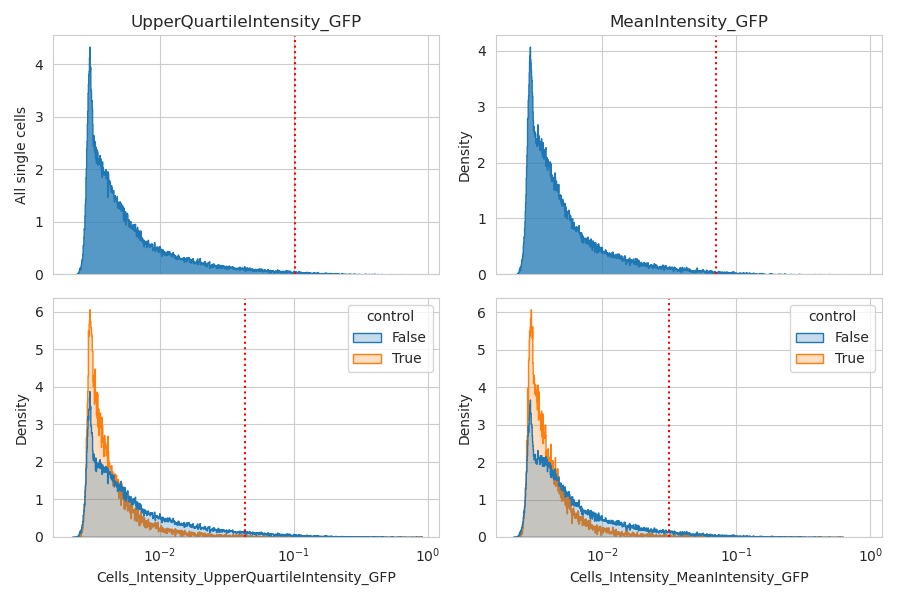

0.0033905722317285397
0.00327546593600354


In [57]:
listOfPlates=annot_df.Metadata_Plate.unique().tolist();

scaler0 = preprocessing.MinMaxScaler(feature_range=(0,1))

df_inten = pd.DataFrame();
df_inten_scaled_perPlate = pd.DataFrame();
# listOfPlates=['20X_CP_CP127_1']
for p in listOfPlates: #[0:1]:
    fileNameToSave=rootDir+'/backend/plate_raw_intensity_features/'+batch+'/df_intensityFeatures_'+p;
    intFeaturesDf=pd.read_pickle(fileNameToSave, compression='infer');    
    df_inten=df_inten.append(intFeaturesDf, ignore_index=True)  
    df_inten_scaled0 = intFeaturesDf.copy()
    intFeatures=intFeaturesDf.columns[intFeaturesDf.columns.str.contains("GFP")].tolist()
    for ifi in intFeatures:
        qpi=intFeaturesDf[ifi].quantile(0.999)
        intFeaturesDf[ifi]=intFeaturesDf[ifi].clip(0, qpi)
        
        
    dataScaled=scaler0.fit_transform(intFeaturesDf.loc[:,intFeatures])
    df_inten_scaled0[intFeatures]=dataScaled
    df_inten_scaled_perPlate =df_inten_scaled_perPlate.append(df_inten_scaled0, ignore_index=True)  
print(df_inten.shape)   

df_inten=pd.merge(df_inten, annot_df, how='inner', on=['Metadata_Plate','Metadata_Well']);
df_inten_scaled_perPlate=pd.merge(df_inten_scaled_perPlate, annot_df, how='inner', on=['Metadata_Plate','Metadata_Well']);

intFeatures=['Cells_Intensity_UpperQuartileIntensity_GFP',
 'Cells_Intensity_MeanIntensity_GFP']
# Cells_Intensity_UpperQuartileIntensity_DsRed
# Cells_Intensity_UpperQuartileIntensity_Protein
log_scale_enabled=True
binss=1000

rcParams['patch.force_edgecolor'] = False
# df_inten=df_inten_scaled_perPlate.copy()
perc95all_m1a_x=[]
perc95all_m1b_x=[]
fig, axes = plt.subplots(2,len(intFeatures), figsize=(9,6),sharex=True)



for i in range(len(intFeatures)):
    #### Method 1 -a
    allDataTandU=df_inten[intFeatures[i]].values
#     sns.distplot(allDataTandU,kde=False,bins=2000,label="T+U",ax=axes[0,i],color="navy")
    sns.histplot(data=df_inten,x=intFeatures[i], bins=binss,stat="density",\
             element="step",common_norm=False,legend=True,log_scale=log_scale_enabled,ax=axes[0,i])

    perc95=np.percentile(allDataTandU, 99);axes[0,i].axvline(x=perc95,linestyle=':',color="r")
    perc95all_m1a_x.append(perc95);
    axes[0,i].set_title('_'.join(intFeatures[i].split('_')[2:]));
#     axes[0,0].set_ylabel('Method 1- a');
    axes[0,0].set_ylabel('All single cells');

    #### Method 1 -b
#     data2plotTrans=df_inten[~df_inten['Variant'].isin(untrans_vars)][intFeatures[i]].values
    data2plotUtrans=df_inten[df_inten['control']][intFeatures[i]].values

    sns.histplot(data=df_inten,x=intFeatures[i], bins=binss,stat="density",\
             hue="control",element="step",common_norm=False,legend=True,log_scale=log_scale_enabled,ax=axes[1,i])

    print(np.percentile(data2plotUtrans, 40))
    perc95=np.percentile(data2plotUtrans, 99);axes[1,i].axvline(x=perc95,linestyle=':',color="r");

    perc95all_m1b_x.append(perc95)
plt.tight_layout()
# axes[1,0].legend();

#### 4. Generate replicate level profiles based on fixed cell mean intensity thrsh
- For this batch all the cells are assumed to be transfected and therefore transfection_params_dict={} 

In [5]:
transfection_params_dict={} 

feature_scaling_params_dict={'feature_scaler': 'Robust'}
all_params={}
all_params['enrichement_profiles_params']={}
all_params['transfection_params_dict']=transfection_params_dict
all_params['feature_scaling_params_dict']=feature_scaling_params_dict
all_params['save_single_cells']=True


listOfBatchPlates=annot_df.Metadata_batch_Plate.unique().tolist();

for bp in listOfBatchPlates:
    preprocessing.generate_population_profiles(bp,annot_df,rootDir,all_params);

Processing  2022_08_22_Batch_1 2022_08_08_PPL8_100-800
cp_features: 2859
cols2remove_manyNulls ['Cells_Correlation_Costes_GFP_DNA', 'Nuclei_Correlation_Costes_GFP_AGP', 'Cytoplasm_Correlation_Costes_GFP_DNA', 'Cytoplasm_Correlation_Costes_DNA_AGP', 'Cells_Correlation_Costes_GFP_Mito', 'Cytoplasm_Correlation_Costes_DNA_GFP', 'Nuclei_Correlation_Costes_DNA_AGP', 'Nuclei_Correlation_Costes_GFP_Mito', 'Cells_Correlation_Costes_DNA_AGP', 'Nuclei_Correlation_Costes_AGP_GFP', 'Cells_Correlation_Costes_GFP_AGP', 'Cytoplasm_Correlation_Costes_GFP_AGP', 'Nuclei_Correlation_Costes_GFP_DNA', 'Cytoplasm_Correlation_Costes_GFP_Mito']
cols2remove_lowVars ['Nuclei_Location_CenterMassIntensity_Z_GFP', 'Cells_Location_CenterMassIntensity_Z_DNA', 'Cells_Location_MaxIntensity_Z_DNA', 'Cytoplasm_Location_MaxIntensity_Z_DNA', 'Nuclei_Location_CenterMassIntensity_Z_AGP', 'Nuclei_Location_CenterMassIntensity_Z_DNA', 'Cells_Location_MaxIntensity_Z_Mito', 'Cytoplasm_Location_MaxIntensity_Z_GFP', 'Cells_Location

/home/ubuntu/workspace_rare/2017_09_27_RareDiseases_Taipale/utils/preprocessing.py:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  standardized_per_plate_sc['transfection_status']=1
/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/singlecell/save/save_pandas_dfs.py:40: RuntimeWarning: compression has no effect when passing a non-binary object as input.
  df.to_csv(fd,index=False,compression='gzip')


(68930, 2817) (274, 3762)
(68930, 2817)
(274, 2817)


/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/singlecell/save/save_pandas_dfs.py:40: RuntimeWarning: compression has no effect when passing a non-binary object as input.
  df.to_csv(fd,index=False,compression='gzip')


--- 6774.523024082184 seconds ---


#### 5. Load and preprocess replicate level profiles

In [4]:
# sc_per_plate_scaling # 'sc_scaled_per_plate','raw'
# zscored_profiles # 'untransfected','untransfected_stringent'
feature_scaling_params_dict={'sc_per_plate_scaling':'sc_scaled_per_plate',\
                             'zscored_profiles':[False,'untransfected'],\
                             'post_scale_all_profiles':[False,'Standard']} 

dirs_params_dict={'rootDir':rootDir,\
                  'profiles_folder_in_workspace': 'population_profiles'}
read_pop_params={}
read_pop_params['dirs_params_dict']=dirs_params_dict
read_pop_params['feature_scaling_params_dict']=feature_scaling_params_dict
read_pop_params['protein_channel_suffix']='GFP'

df_scaled_annot,cpFeats_A,cpFeats_P,cpFeats_NP=\
meanProfileAnalysis.read_merge_preprocess_meanProfiles(annot_df,read_pop_params);

# dfTransSummary = df_scaled_annot[['Metadata_batch_Plate','Metadata_Sample_Unique','n_transf','n_untransf','transf_Ratio']]
dfTransSummary=df_scaled_annot[annot_df.columns.tolist()+['n_transf','n_untransf','transf_Ratio']];


/home/ubuntu/bucket/projects/2017_10_19_Profiling_rare_ORFs/workspace//population_profiles/2022_08_22_Batch_1/2022_08_08_PPL8_100-800/2022_08_08_PPL8_100-800.csv.gz
cp_features: 2817
cols2remove_manyNulls []
cols2remove_lowVars []
len cp_features_analysis/nan cols/low vars: 2817 0 0
cp_features: 2817
cols2remove_manyNulls []
cols2remove_lowVars []
len cp_features_analysis/nan cols/low vars: 2817 0 0


#### 6. Calculate replicate correlation of profiles
Save curve plots and values to results/replicate_corr_curves

p Protein_Channel


<IPython.core.display.Javascript object>


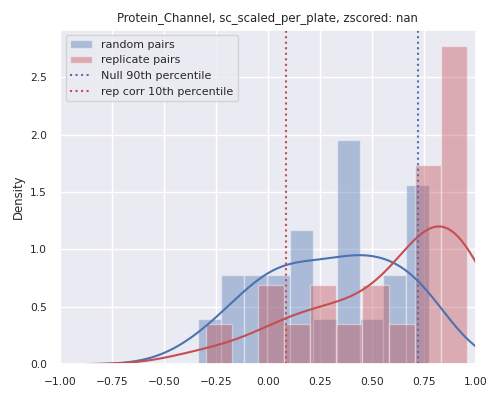

/home/ubuntu/anaconda3/envs/rare/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/rare/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


np NonProtein_Channels


<IPython.core.display.Javascript object>


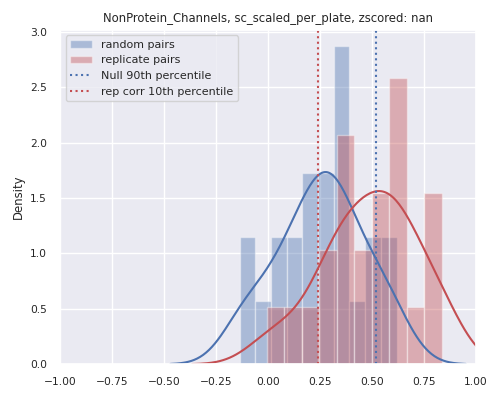

/home/ubuntu/anaconda3/envs/rare/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/rare/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [11]:
from singlecell.process.replicate_correlation import replicate_null_corr_coefs
from singlecell.process import normalize_funcs

df_rep_level=df_scaled_annot[df_scaled_annot['transfection_status']==1].reset_index(drop=True)

df_rep_level_scaled=normalize_funcs.standardize_per_catX(df_rep_level,'Metadata_batch_Plate',cpFeats_P+cpFeats_NP).copy();
# df_rep_level_scaled = normalize_funcs.standardize_df_columns(df_rep_level,cpFeats_P+cpFeats_NP,'Standard')

nOfReps=df_rep_level_scaled.groupby(['Metadata_Sample_Unique']).size().reset_index()
pairWithReplicates=nOfReps.loc[nOfReps[0]!=1,:].reset_index()['Metadata_Sample_Unique']#.groupby([0]).size()

scal_status=df_rep_level_scaled['normalization'].unique()[0]
# zscor_status=df_rep_level_scaled['zscored'].unique().astype(str)[0]
zscor_status='nan'
# if not np.isnan(df_rep_level_scaled['zscored'].unique()[0])

saveDir=rootDir+'/results/replicate_corr_curves/'+batch
# 
os.makedirs(saveDir, exist_ok=True)

pertColName='Metadata_Sample_Unique'
repCor4impactList=[]
for f,ch,t in zip([cpFeats_P,cpFeats_NP],['p','np'],['Protein_Channel','NonProtein_Channels']):
    print(ch,t)
    t2=t+', '+scal_status+', zscored: '+zscor_status
    fh_2save,repCorrDf=replicate_null_corr_coefs(df_rep_level_scaled,pertColName,f,1,title=t2,hist_bins=10)
    fh_2save.savefig(saveDir+'/'+ch+'_'+scal_status+'_'+zscor_status+'.png')
    repCorrDf=repCorrDf.add_suffix('_'+ch)
    repCor4impactList.append(repCorrDf);
    
repCorr_df_avg=pd.concat(repCor4impactList,axis=1).reset_index().rename(columns={'index':pertColName})
repCorr_df_avg.to_csv(saveDir+'/'+scal_status+'_'+zscor_status+'.csv',index=False)
df_rep_level_scaled=pd.merge(df_rep_level_scaled,repCorr_df_avg,how='left',on=pertColName)

#### 7. Calculate WT-MT impact scores and save
- Approach 1: average replicate level profiles and score treatment level profiles
- Approach 2: calculate impact scores per plate

In [33]:
# Approach 1

df_rep_level_scaled['Gene-dose']=df_rep_level_scaled['Gene']+'-'+df_rep_level_scaled['vTitre'].astype(str)
wt_mt_cols=['Gene-dose','Metadata_Sample_Unique']
impact_scores_trt_profs = impactscore.impact_score_wt_mt(df_rep_level_scaled,repCorr_df_avg,[cpFeats_P,cpFeats_NP],\
                                                        wt_mt_cols);
   
saveDir=rootDir+'/results/Impact-Scores/Method-MeanProfiles/'+batch
os.makedirs(saveDir, exist_ok=True)
impact_scores_trt_profs.to_csv(saveDir+'/impact_scores_trt_'+today.strftime("%Y%m%d")+'.csv',index=False)

In [35]:
# print(impact_scores_trt_profs.to_markdown())

In [46]:
control_type='negcon'
neg_con_unq=annot_df.loc[(annot_df['control_type']==control_type) &(annot_df['vTitre']==6),\
                         'Metadata_Sample_Unique'].tolist()
control_type='poscon'
pos_con_unq=annot_df.loc[(annot_df['control_type']==control_type) &(annot_df['vTitre']==6),\
                         'Metadata_Sample_Unique'].tolist()

In [48]:
print(impact_scores_trt_profs.to_markdown())

In [62]:
annot_df[(annot_df['control_type']=='negcon') &(annot_df['vTitre']==6)].groupby('Metadata_Sample_Unique').size()

Metadata_Sample_Unique
ATG5-6      1
BCL2L1-6    1
CFLAR-6     1
CLOCK-6     1
HIF1-6      1
IKBKE-6     1
MAPK13-6    1
MAPK9-6     1
PRKACB-6    1
RHEB-6      1
SGK3-6      1
SLIRP-6     1
STAT1-6     1
ZBTB24-6    1
dtype: int64

In [55]:
print(impact_scores_trt_profs[impact_scores_trt_profs['Metadata_Sample_Unique'].isin(pos_con_unq)].to_markdown(index=False))

| Metadata_Sample_Unique   |      cc_p | Gene-dose   |   wt_RepCor_p |      cc_np |   wt_RepCor_np |   RepCor_p |   Rand90Perc_p |   Rep10Perc_p |   RepCor_np |   Rand90Perc_np |   Rep10Perc_np |
|:-------------------------|----------:|:------------|--------------:|-----------:|---------------:|-----------:|---------------:|--------------:|------------:|----------------:|---------------:|
| ALK A1234-6              | -0.820451 | ALK-6       |    nan        | -0.0139152 |     nan        |  nan       |       0.722659 |     0.0868252 |  nan        |        0.518714 |       0.240371 |
| ALK F1174L-6             | -0.793734 | ALK-6       |    nan        | -0.247326  |     nan        |  nan       |       0.722659 |     0.0868252 |  nan        |        0.518714 |       0.240371 |
| ALK R1275Q-6             | -0.763686 | ALK-6       |    nan        | -0.317256  |     nan        |  nan       |       0.722659 |     0.0868252 |  nan        |        0.518714 |       0.240371 |
| ALK T1151M-6      

In [56]:
print(repCorr_df_avg[repCorr_df_avg['Metadata_Sample_Unique'].isin(neg_con_unq)].to_markdown(index=False))

| Metadata_Sample_Unique   |   RepCor_p |   Rand90Perc_p |   Rep10Perc_p |   RepCor_np |   Rand90Perc_np |   Rep10Perc_np |
|:-------------------------|-----------:|---------------:|--------------:|------------:|----------------:|---------------:|
| MAPK13-6                 |        nan |       0.722659 |     0.0868252 |         nan |        0.518714 |       0.240371 |
| MAPK9-6                  |        nan |       0.722659 |     0.0868252 |         nan |        0.518714 |       0.240371 |
| ATG5-6                   |        nan |       0.722659 |     0.0868252 |         nan |        0.518714 |       0.240371 |
| PRKACB-6                 |        nan |       0.722659 |     0.0868252 |         nan |        0.518714 |       0.240371 |
| BCL2L1-6                 |        nan |       0.722659 |     0.0868252 |         nan |        0.518714 |       0.240371 |
| RHEB-6                   |        nan |       0.722659 |     0.0868252 |         nan |        0.518714 |       0.240371 |
| CFLAR-

In [57]:
# impact_scores_trt_profs
# repCorr_df_avg

,Metadata_Sample_Unique,RepCor_p,Rand90Perc_p,Rep10Perc_p,RepCor_np,Rand90Perc_np,Rep10Perc_np
0,ACSF3-18,NaN,0.722659,0.086825,NaN,0.518714,0.240371
1,ACSF3-12,NaN,0.722659,0.086825,NaN,0.518714,0.240371
2,ACSF3 PRO243LEU-18,0.79559,0.722659,0.086825,0.388187,0.518714,0.240371
3,ACSF3 PRO243LEU-12,0.565464,0.722659,0.086825,0.252055,0.518714,0.240371
4,ACY1-18,NaN,0.722659,0.086825,NaN,0.518714,0.240371
...,...,...,...,...,...,...,...
246,ALK R1275Q-3,NaN,0.722659,0.086825,NaN,0.518714,0.240371
247,IKBKE-6,NaN,0.722659,0.086825,NaN,0.518714,0.240371
248,IKBKE-3,NaN,0.722659,0.086825,NaN,0.518714,0.240371
249,ZBTB24-6,NaN,0.722659,0.086825,NaN,0.518714,0.240371


In [24]:
featColNames_ls=[cpFeats_P,cpFeats_NP]
impact_scores_df_chs_ls=[]
for f,ch in zip(featColNames_ls,['p','np']):
    impact_corr_mat=df_rep_level_scaled.groupby([wt_mt_cols[0],wt_mt_cols[1]]).mean()[f].T.corr()

    genes_variant_size=impact_corr_mat.groupby(wt_mt_cols[0]).size().reset_index()
    genes_with_variant=list(set(genes_variant_size.loc[genes_variant_size[0]>1,wt_mt_cols[0]].tolist()) &\
                            set(df_rep_level_scaled[wt_mt_cols[1]].unique().tolist()))
    impact_scores_df_ls=[]
    for g in genes_with_variant:
        per_gene_df=impact_corr_mat.loc[g][g][g].reset_index()
    #     per_gene_df['Gene']=per_gene_df.columns[1]
        per_gene_df[wt_mt_cols[0]]=g
        per_gene_df['wt_RepCor_'+ch]=repCorr_df_avg.loc[repCorr_df_avg[wt_mt_cols[1]]==g,'RepCor_'+ch].values[0]

        impact_scores_df_ls.append(per_gene_df.rename(columns={g:'cc_'+ch}))

    impact_scores_df=pd.concat(impact_scores_df_ls,ignore_index=True)
    impact_scores_df_chs_ls.append(impact_scores_df)

impact_scores_df_chs=pd.concat(impact_scores_df_chs_ls,axis=1).T.drop_duplicates().T

KeyError: 'ALK-18'

In [30]:
# impact_corr_mat.loc[g][g]
df_rep_level_scaled[['Gene-dose','Metadata_Sample_Unique','vTitre']]

,Gene-dose,Metadata_Sample_Unique,vTitre
0,ACSF3-18,ACSF3-18,18
1,ACSF3-6,ACSF3-12,12
2,ACSF3-18,ACSF3 PRO243LEU-18,18
3,ACSF3-6,ACSF3 PRO243LEU-12,12
4,ACSF3-18,ACSF3 PRO243LEU-18,18
...,...,...,...
269,STAT1-6,ALK R1275Q-3,3
270,ZBTB24-18,IKBKE-6,6
271,ZBTB24-6,IKBKE-3,3
272,MAPK13-12,ZBTB24-6,6


In [11]:
# pd.concat(repCor4impactList,axis=1).reset_index()

In [302]:
results_df.Variant.unique()

array(['IMPDH1', 'IMPDH1_D311', 'IMPDH1_H457P', 'IMPDH1_R309P',
       'IMPDH1_V353I', 'ALK', 'ALK_A1234', 'ALK_R1275Q', 'ALK_T1151M',
       'ALK_F1174L'], dtype=object)

In [257]:
palette = sns.color_palette("Paired",20)

In [260]:
palette[1]

(0.12156862745098039, 0.47058823529411764, 0.7058823529411765)